

<h1> <b> <centre> DA5401 Assignment 5 </b> </centre> </h2>
<h4> <b> <centre> Name: Pawar Devesh Pramod </centre></b> </h4>
<h4> <b> <centre> Roll No: ME22B176  </centre></b> </h4>
<h4> <b> <centre> Date of Submission 05/10/2025 </centre></b> </h4>


<h3> <b> Objective: </b> <h3> 
<p style="font-size: 18px;">This assignment aims to deepen the understanding of the challenges in real-world machine
learning, specifically in multi-label classification, by utilizing advanced non-linear dimensionality
reduction techniques such as t-SNE and Isomap. We will visually inspect the data for issues such as
noisy labels, outliers, and hard-to-learn data points, sparking curiosity about data veracity in a biological
context. </p>

<h3> <b> 1. Problem Statement </b> </h3>
<p style="font-size: 18 px;">
You are a data scientist analyzing gene expression data. You have been given the Yeast Dataset, where
each data point (instance) represents an experiment, and the features are gene expression levels. The
target is a set of 14 functional categories (labels) to which the gene product may belong (multi-label
classification). This dataset, despite being standardized, can still exhibit data veracity issues:
1.​ Noisy/Ambiguous Labels: Genes whose functions span multiple categories or are misclassified.
2.​ Outliers: Experiments with highly unusual gene expression profiles.
3.​ Hard-to-Learn Samples: Data points lying in regions where functional categories are thoroughly
mixed.
Your task is to apply t-SNE and Isomap to the feature vectors to visually expose these data quality
issues, thereby understanding the challenges a classifier would face.
You will submit a Jupyter Notebook with your complete code, visualizations, and a plausible story that
explains your findings. The notebook should be well-commented, reproducible, and easy to follow.</p>

<p style="font-size: 18px;"> Dataset: 
- <a href="http://mulan.sourceforge.net/datasets-mlc.html">Mulan Yeast Dataset </a> 
</p>

## Tasks

First, we import the necessary libraries for data manipulation, dimensionality reduction, and visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from scipy.io import arff
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap

# Set plot style for better aesthetics
sns.set_style('whitegrid')
%matplotlib inline

## Part A: Preprocessing and Initial Setup

### 1. Data Loading

We will download the Yeast dataset from the MULAN repository. The dataset is in `.arff` format, which we will parse using `scipy`.

In [2]:

file_path = 'yeast/yeast.arff'
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)


# Identify feature and label names
feature_names = meta.names()[:103]
label_names = meta.names()[103:]

# Separate features (X) and labels (Y)
X = df[feature_names].to_numpy()

# The labels are loaded as bytes, so we decode them and convert to integers
Y_df = df[label_names].apply(lambda col: col.str.decode('utf-8').astype(int))
Y = Y_df.to_numpy()

### 2. Dimensionality Check

Let's report the initial dimensions of our feature and label matrices.

In [3]:
print(f"Feature matrix X has shape: {X.shape}")
print(f"There are {X.shape[0]} data points (experiments) and {X.shape[1]} features (gene expression levels).")
print("\n")
print(f"Label matrix Y has shape: {Y.shape}")
print(f"There are {Y.shape[1]} possible labels (functional categories).")

Feature matrix X has shape: (2417, 103)
There are 2417 data points (experiments) and 103 features (gene expression levels).


Label matrix Y has shape: (2417, 14)
There are 14 possible labels (functional categories).


### 3. Label Selection for Visualization

Visualizing 14 labels simultaneously is challenging. We will simplify this by creating a new target variable for coloring. This variable will represent the **two most frequent single-label classes**, the **most frequent multi-label combination**, and an **"Other"** category for everything else.

In [4]:
# Find the two most frequent single-label classes 
label_counts_per_instance = Y.sum(axis=1)
single_label_mask = (label_counts_per_instance == 1)
Y_single = Y[single_label_mask]

# Sum columns to find frequencies
single_label_frequencies = Y_single.sum(axis=0)
top_2_single_indices = np.argsort(single_label_frequencies)[-2:]

most_frequent_single_idx = top_2_single_indices[1]
second_most_frequent_single_idx = top_2_single_indices[0]

# Find the most frequent multi-label combination 
multi_label_mask = (label_counts_per_instance > 1)
Y_multi = Y[multi_label_mask]

# Convert rows to tuples to count them
multi_label_tuples = [tuple(row) for row in Y_multi]
most_frequent_combo_tuple = Counter(multi_label_tuples).most_common(1)[0][0]
most_frequent_combo = np.array(most_frequent_combo_tuple)

print(f"Most frequent single label: '{label_names[most_frequent_single_idx]}', with frequency {single_label_frequencies[most_frequent_single_idx]}")
print(f"Second most frequent single label: '{label_names[second_most_frequent_single_idx]}', with frequency {single_label_frequencies[second_most_frequent_single_idx]}")
combo_labels = [label_names[i] for i, val in enumerate(most_frequent_combo) if val == 1]
print(f"Most frequent multi-label combination: {combo_labels}")

# Create the new categorical target variable for coloring 
# 0: Most frequent single label
# 1: Second most frequent single label
# 2: Most frequent multi-label combo
# 3: Other
y_color = np.full(Y.shape[0], 3, dtype=int) # Default to 'Other'

for i in range(Y.shape[0]):
    if single_label_mask[i]:
        if Y[i, most_frequent_single_idx] == 1:
            y_color[i] = 2
        elif Y[i, second_most_frequent_single_idx] == 1:
            y_color[i] = 1
    elif multi_label_mask[i]:
        if np.array_equal(Y[i], most_frequent_combo):
            y_color[i] = 0

# For legend creation
color_map_legend = {
    0: f'Single: {label_names[most_frequent_single_idx]}',
    1: f'Single: {label_names[second_most_frequent_single_idx]}',
    2: 'Multi: Top Combination',
    3: 'Other'
}

print("\nNumber of points in each category:")
print(pd.Series(y_color).value_counts().rename(index=color_map_legend))

Most frequent single label: 'Class1', with frequency 32
Second most frequent single label: 'Class14', with frequency 0
Most frequent multi-label combination: ['Class3', 'Class4', 'Class12', 'Class13']

Number of points in each category:
Other                     2148
Single: Class1             237
Multi: Top Combination      32
Name: count, dtype: int64


### 4. Scaling

**Why is scaling crucial before applying distance-based dimensionality reduction techniques?**

Algorithms like t-SNE and Isomap are based on calculating distances between data points to understand their relationships (either locally or globally). If the features in the dataset have vastly different scales (e.g., one feature ranges from 0-1 and another from 0-1000), the feature with the larger scale will dominate the distance calculation. This can completely mask the contribution of features with smaller scales, even if they are more informative. 

By **standardizing** the data (scaling to have a mean of 0 and a standard deviation of 1), we ensure that all features contribute equally to the distance computations. This leads to a more meaningful and accurate representation of the data's underlying structure in the lower-dimensional space.

In [5]:
# Apply Standardization to the feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data has been scaled.")
print(f"Mean of the first feature after scaling: {X_scaled[:, 0].mean():.2f}")
print(f"Standard deviation of the first feature after scaling: {X_scaled[:, 0].std():.2f}")

Data has been scaled.
Mean of the first feature after scaling: 0.00
Standard deviation of the first feature after scaling: 1.00


## Part B: t-SNE and Veracity Inspection

### 1. t-SNE Implementation

We will now apply t-SNE to the scaled feature matrix. A key hyperparameter for t-SNE is `perplexity`, which relates to the number of nearest neighbors considered for each point. We will experiment with a few values to see how the visualization changes.

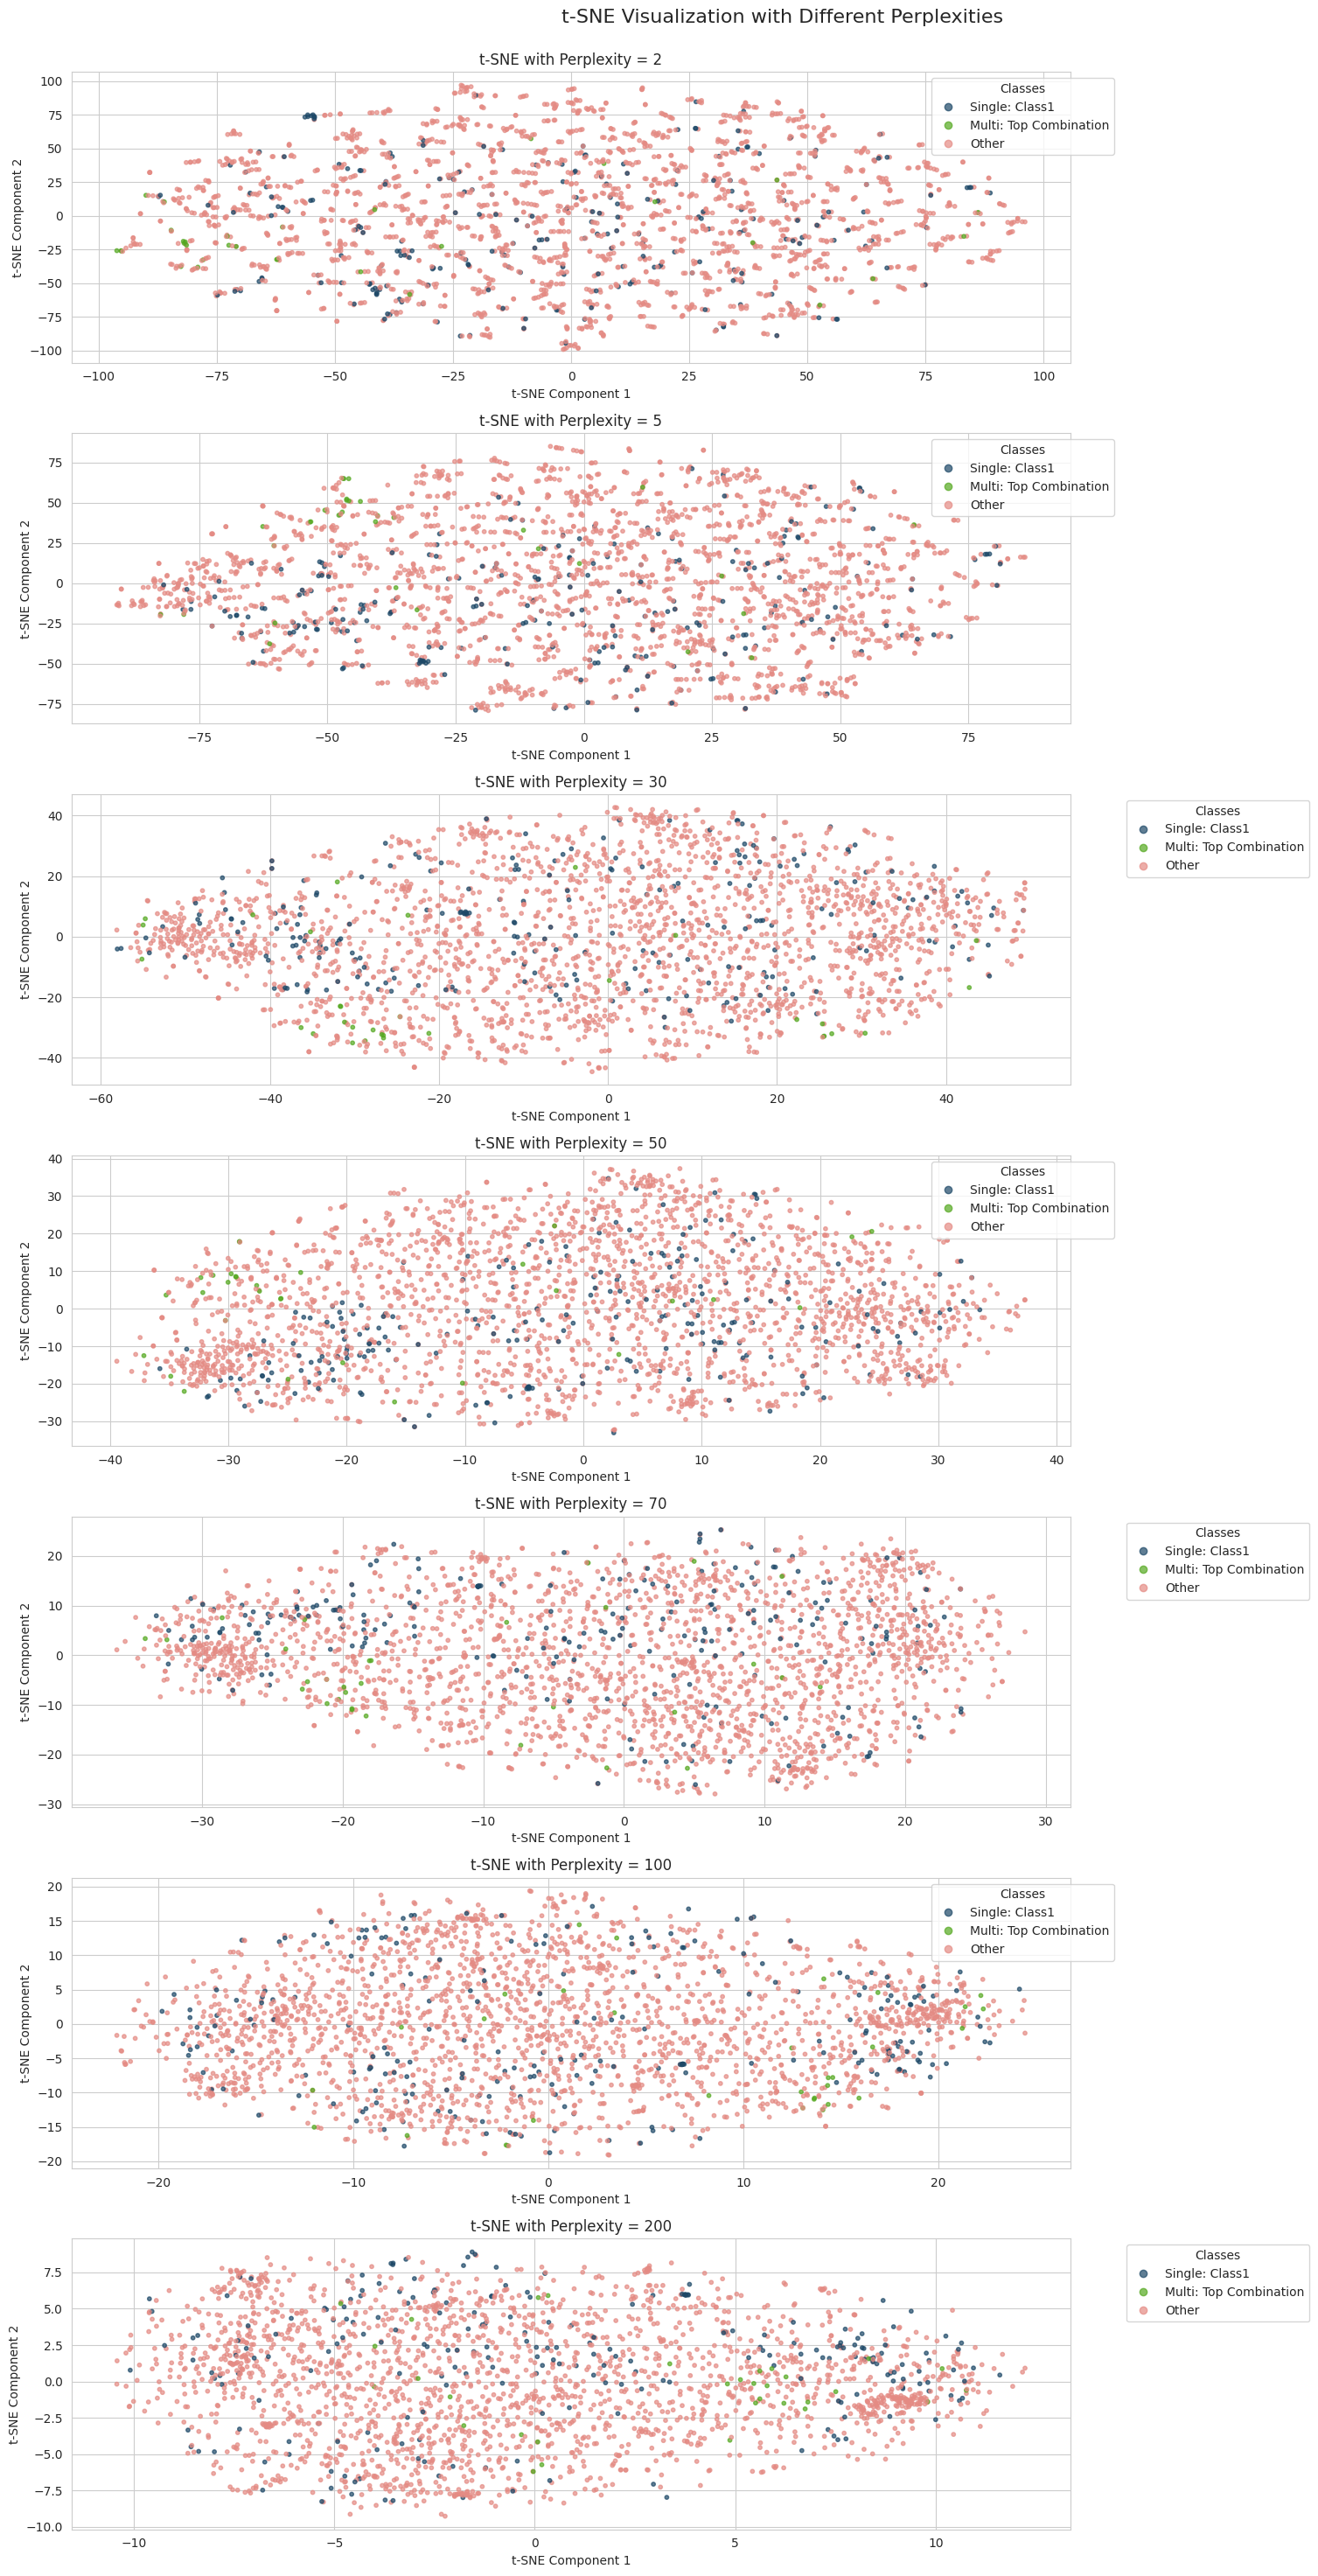

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import re # <-- Make sure to import the regular expression module

# Assuming X_scaled, y_color, and color_map_legend are defined

perplexities = [2, 5, 30, 50, 70, 100, 200]
fig, axes = plt.subplots(7, 1, figsize=(18, 30))

custom_colors = ["#1d4867", '#ff7f0e', "#54a820", "#E48B84BD"]
custom_cmap = ListedColormap(custom_colors)

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_scaled)
    
    ax = axes[i]
    
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_color, cmap=custom_cmap, alpha=0.7, s=10)
    
    ax.set_title(f't-SNE with Perplexity = {perplexity}')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    handles, numeric_labels = scatter.legend_elements()
    
    # --- CORRECTED LINE USING REGEX ---
    # Find the digit inside the LaTeX string, then convert it to an int
    text_labels = [color_map_legend[int(re.search(r'\d+', label).group(0))] for label in numeric_labels]
    
    ax.legend(handles=handles, labels=text_labels, title="Classes", bbox_to_anchor=(1.05, 1))

plt.suptitle('t-SNE Visualization with Different Perplexities', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
plt.show()

**Analysis**
The series of plots clearly demonstrates how perplexity, which roughly corresponds to the number of nearest neighbors for each point, tunes the balance between preserving the local and global structure of the data.

- Low Perplexity (5, 10): These plots look fragmented and "stringy," with many small, tight, disconnected clumps. This indicates that the algorithm is focusing too heavily on immediate neighbors, which can create an illusion of clusters that aren't real and fails to capture the broader relationships in the data.

- Mid-Range Perplexity (30, 50): These plots provide the most balanced and interpretable view. They successfully merge the small, meaningless clumps into larger, more coherent structures. We can see a main, large cloud of "Other" points, with the "Single: Class1" points forming a denser, more distinct region within it. These visualizations reveal both local groupings and the overall global arrangement.

- High Perplexity (70, 100, 200): As the perplexity increases, the detailed local structures begin to disappear. The clusters merge and the entire plot starts to converge into a single, large, rounded ball. This phenomenon, known as "crowding," is especially evident at perplexity 200, where nearly all the fine-grained detail is lost. The global structure is overemphasized at the expense of local information.

**Justification for Final Choice of Perplexity:**

We can conclude that the choice of perplexity changes the t-SNE visualization, with values 30 is providing the most insightful view of this particular dataset, with some clustering pattern visible.

### 2. Visualization

Now, we create a larger, more detailed plot using our chosen perplexity value.

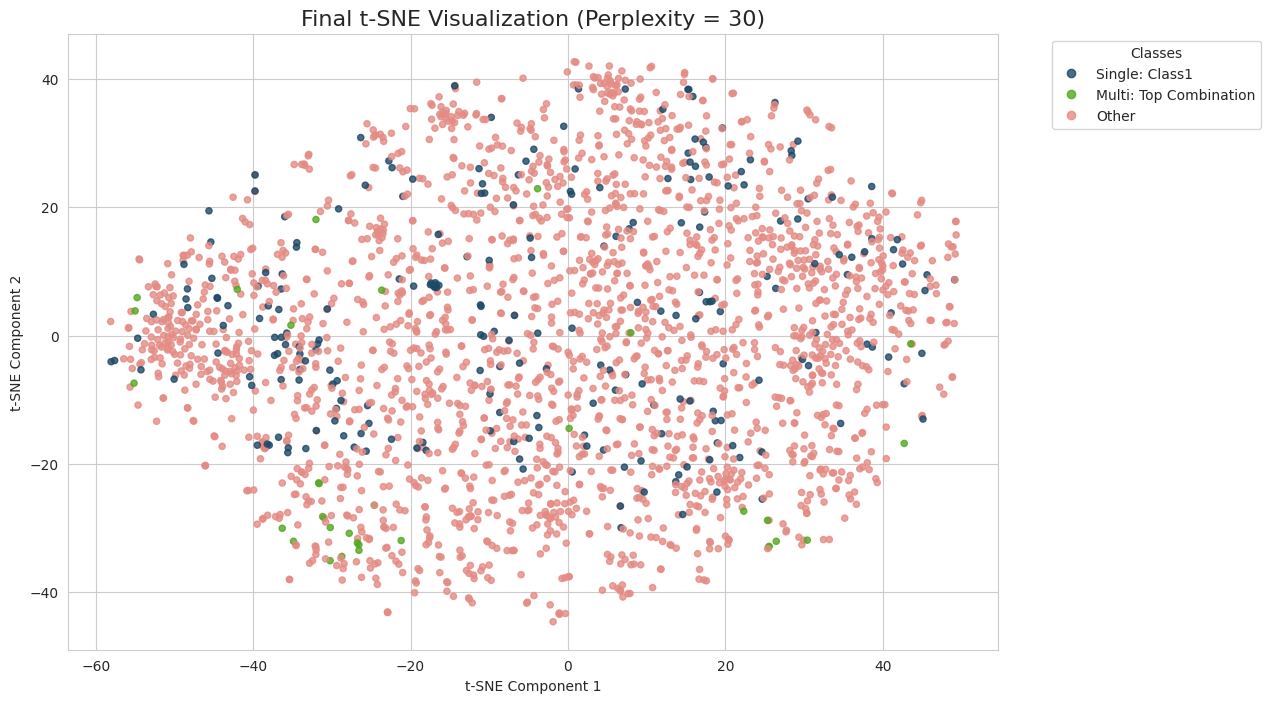

In [7]:
# Final t-SNE implementation with chosen perplexity
final_perplexity = 30
tsne = TSNE(n_components=2, perplexity=final_perplexity, random_state=42, init='pca', learning_rate='auto')
X_tsne_final = tsne.fit_transform(X_scaled)
custom_colors = ["#1d4867", '#ff7f0e', "#54a820", "#E48B84BD"]
custom_cmap = ListedColormap(custom_colors)
# Plotting the final t-SNE result
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=y_color, cmap=custom_cmap, alpha=0.8, s=20)

handles, numeric_labels = scatter.legend_elements()

# --- CORRECTED LINE USING REGEX ---
# Find the digit inside the LaTeX string, then convert it to an int
text_labels = [color_map_legend[int(re.search(r'\d+', label).group(0))] for label in numeric_labels]

plt.legend(handles=handles, labels=text_labels, title="Classes", bbox_to_anchor=(1.05, 1))


plt.title(f'Final t-SNE Visualization (Perplexity = {final_perplexity})', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### 3. Veracity Inspection

The t-SNE plot allows us to visually identify several data quality issues:

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from matplotlib.colors import ListedColormap
# from matplotlib.patches import Ellipse
# import re

# # Assuming X_scaled, y_color, and color_map_legend are already defined from your assignment


# # Final t-SNE implementation with chosen perplexity
# final_perplexity = 30
# tsne = TSNE(n_components=2, perplexity=final_perplexity, random_state=42, init='pca', learning_rate='auto')
# X_tsne_final = tsne.fit_transform(X_scaled)

# # Define colors and colormap
# custom_colors = ["#1d4867", '#ff7f0e', "#54a820", "#E48B84BD"]
# custom_cmap = ListedColormap(custom_colors)

# # Plotting the final t-SNE result
# fig, ax = plt.subplots(figsize=(14, 10)) # Use fig, ax for adding patches
# scatter = ax.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=y_color, cmap=custom_cmap, alpha=0.8, s=20, zorder=2)


# # 1. Highlight a Hard-to-Learn Region with an ellipse
# # This area in the center is where colors are most mixed
# hard_to_learn_region = Ellipse(xy=(0, 0), width=40, height=50, 
#                                edgecolor='red', facecolor='none', lw=2, linestyle='--', zorder=3)
# ax.add_patch(hard_to_learn_region)
# ax.text(22, 0, 'Hard-to-Learn Samples\n(Mixed Colors)', fontsize=12, color='red', ha='left')

# # 2. Point to a Noisy/Ambiguous Label
# # An arrow pointing to a point of one color inside a cluster of another
# ax.annotate('Noisy/Ambiguous Label',
#             xy=(-25, 12), # The point to highlight
#             xytext=(-15, 40), # Where the text is
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
#             fontsize=12, ha='center', zorder=4)

# # 3. Point to an Outlier
# # An arrow pointing to an isolated point far from the main clusters
# ax.annotate('Outlier',
#             xy=(23, -58), # The point to highlight
#             xytext=(0, -65), # Where the text is
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
#             fontsize=12, ha='center', zorder=4)




# # Create the legend
# handles, numeric_labels = scatter.legend_elements()
# text_labels = []
# for label in numeric_labels:
#     match = re.search(r'\d+', label)
#     if match:
#         idx = int(match.group(0))
#         if idx < len(color_map_legend):
#             text_labels.append(color_map_legend[idx])
#         else:
#             text_labels.append(f'Class {idx}')
#     else:
#         text_labels.append(label)
# ax.legend(handles=handles, labels=text_labels, title="Classes")

# # Add titles and labels
# ax.set_title(f't-SNE Visualization with Veracity Inspection (Perplexity = {final_perplexity})', fontsize=16)
# ax.set_xlabel('t-SNE Component 1')
# ax.set_ylabel('t-SNE Component 2')

# plt.grid(True)
# plt.show()

### Noisy/Ambiguous Labels ###

Noisy or ambiguous labels are visible as points that are located deep within a cluster of a different color. In the plot, we can identify several instances of this:

- There are numerous dark blue (Single: Class1) points situated alone within the large, diffuse cloud of the light red (Other) category.

- Similarly, there are isolated light red points located inside the denser collections of dark blue points, particularly on the left side of the plot.

These points represent genes whose expression profiles are very similar to one category, yet they are labeled as another. This could be due to a misclassification during data collection or because the gene has multiple functions, making its label inherently ambiguous.

### Outliers

Outliers are identifiable as isolated points or very small clusters that are distant from the main body of data. The plot shows several such points along its periphery, for example, near the coordinates (-60, 0) and (30, -45).

These unusual gene expression patterns could represent several possibilities:

- Experimental Error: The data for these points might be corrupt due to an error in the lab, such as sample contamination or a faulty sensor.

- Rare Biological States: These could be valid experiments that captured a rare cellular process or a response to a unique environmental stressor not present in other samples.

- Unique Gene Functions: The genes might have highly specialized functions, causing their expression patterns to be fundamentally different from the more common functional categories in the dataset.

### Hard-to-Learn Samples

- The hard-to-learn samples are located in the large, central area of the plot where the colors are thoroughly mixed. In this dense region, dark blue, green, and light red points are heavily intermingled with no clear separation.

- A simple classifier, such as a linear model, would struggle immensely in this region because the classes are not linearly separable. A linear classifier works by trying to find a simple line or hyperplane to divide the data. In this mixed-up area, no such simple boundary exists. The decision boundary required to correctly classify these points would be extremely complex and non-linear, leading to a high rate of misclassification for any simple model. This indicates that the gene expression profiles for different functional categories are in many cases, very similar to one another.

## Part C: Isomap and Manifold Learning

### 1. Isomap Implementation

Next, we apply Isomap. Unlike t-SNE, Isomap is a manifold learning technique that focuses on preserving the global structure of the data.

**Fundamental Difference between Isomap and t-SNE:**

The core difference lies in what aspect of the data structure they aim to preserve:

- **t-SNE (Local):** t-SNE focuses on preserving **local similarities**. It models the probability distribution of neighbors for each point in the high-dimensional space and tries to create a low-dimensional embedding where this distribution is similar. It excels at revealing the fine-grained cluster structure but can distort the global arrangement of these clusters.

- **Isomap (Global):** Isomap focuses on preserving **global geodesic distances**. It approximates the distance between two points as the shortest path along the data manifold, rather than a straight line through the ambient space. It first builds a neighborhood graph and then computes the shortest path between all pairs of points. This makes it much better at unfolding a single, continuous manifold and revealing its underlying global geometry.

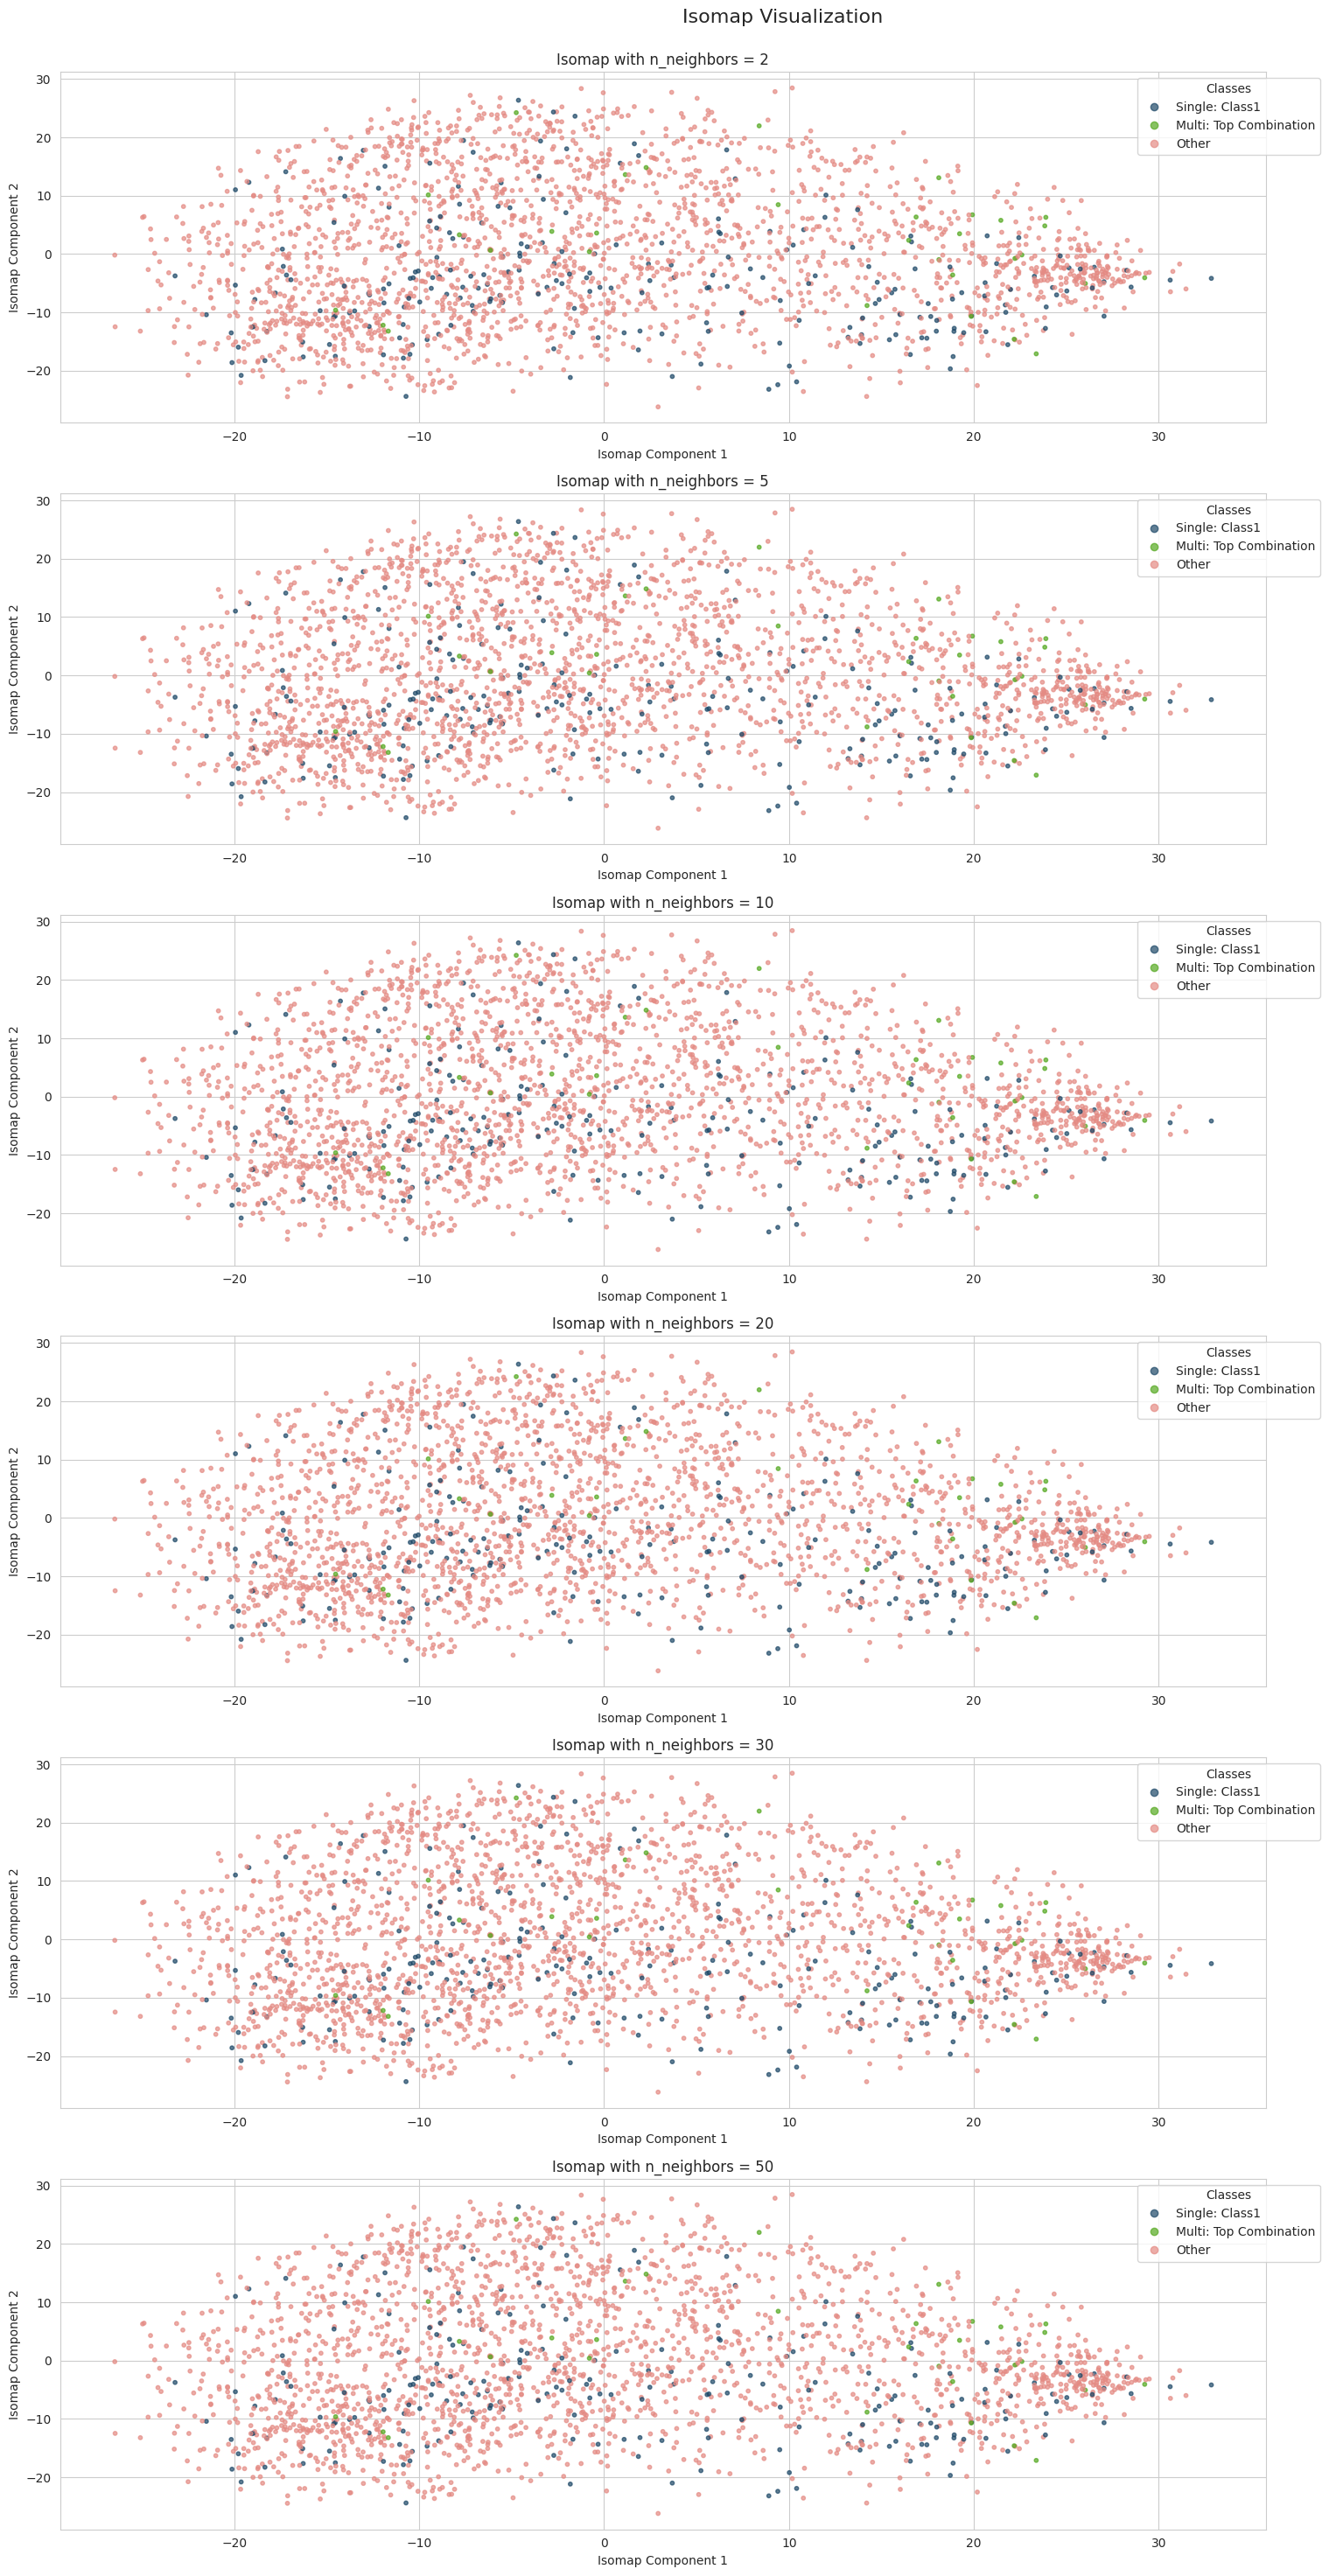

In [9]:
# Apply Isomap. We'll use the default n_neighbors=5, but this can also be tuned.
n_neighors = [2, 5, 10, 20, 30, 50]
fig, axes = plt.subplots(6, 1, figsize=(18, 30))
for i,neighbors in enumerate(n_neighors):
    isomap = Isomap(n_components=2)
    X_isomap = isomap.fit_transform(X_scaled)
    ax = axes[i]
    
    scatter = ax.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y_color, cmap=custom_cmap, alpha=0.7, s=10)
    
    ax.set_title(f'Isomap with n_neighbors = {neighbors}')
    ax.set_xlabel('Isomap Component 1')
    ax.set_ylabel('Isomap Component 2')
    
    handles, numeric_labels = scatter.legend_elements()
    
    # --- CORRECTED LINE USING REGEX ---
    # Find the digit inside the LaTeX string, then convert it to an int
    text_labels = [color_map_legend[int(re.search(r'\d+', label).group(0))] for label in numeric_labels]
    
    ax.legend(handles=handles, labels=text_labels, title="Classes", bbox_to_anchor=(1.05, 1))

plt.suptitle('Isomap Visualization', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
plt.show()


### 2. Visualization

We create a scatter plot of the Isomap coordinates using the same coloring scheme.

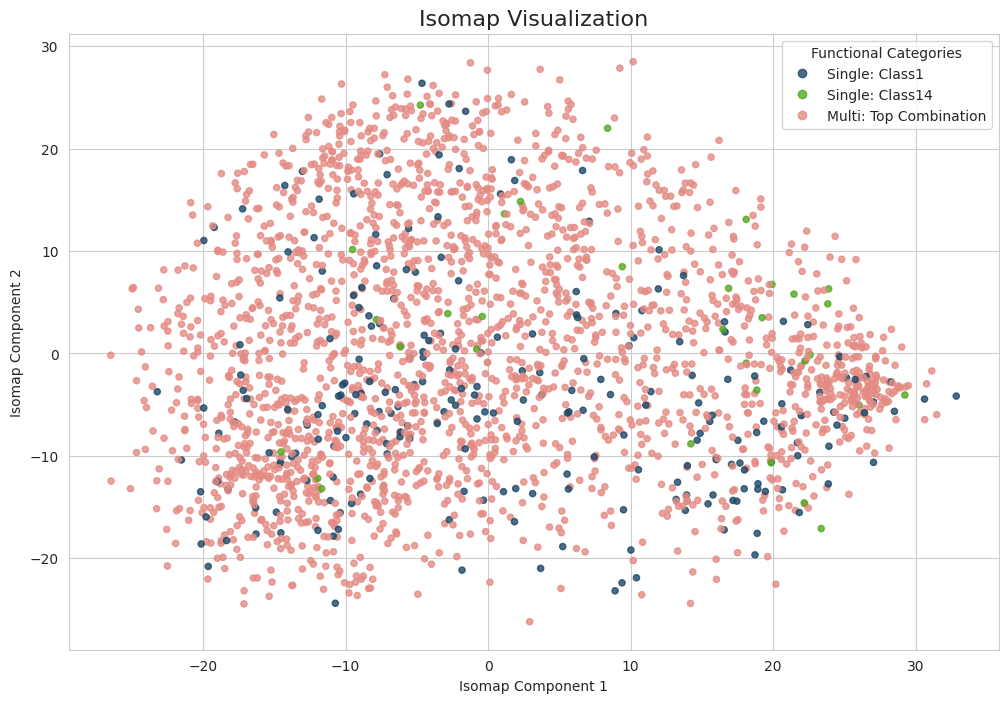

In [10]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y_color, cmap=custom_cmap, alpha=0.8, s=20)

# Create a legend
handles, _ = scatter.legend_elements()
legend_labels = [color_map_legend[i] for i in range(len(color_map_legend))]
plt.legend(handles, legend_labels, title="Functional Categories")

plt.title('Isomap Visualization', fontsize=16)
plt.xlabel('Isomap Component 1')
plt.ylabel('Isomap Component 2')
plt.show()

### 3. Comparison and Curvature



### Isomap vs. t-SNE: Visualizing Global Structure

The Isomap and t-SNE visualizations provide different perspectives on the data's structure.

- Isomap excels at showing the global structure. Your plot displays the data as a single, continuous body. This is because Isomap's goal is to preserve the large-scale geodesic distances between points, effectively "unrolling" the data to reveal its overall shape.

- t-SNE, in contrast, prioritizes preserving local structure. It creates tight, well-defined clusters by ensuring immediate neighbors in the high-dimensional space remain immediate neighbors in the 2D plot. However, it often distorts the distances and relationships between these clusters.

t-SNE is better for identifying distinct local groupings but Isomap provides a more faithful representation of the dataset's overarching layout.

### The Data Manifold and Classification Difficulty

- The concept of a data manifold suggests that high-dimensional data often lies on a lower-dimensional, curved surface. For example a rolled-up scroll in 3D space, its surface is a 2D manifold. Isomap attempts to unroll this scroll to see its true shape.

- Isomap plot suggests the gene expression data lies on a highly curved and complex manifold. We can infer this because the resulting shape is irregular, and more importantly, the different functional categories (colors) are thoroughly interwoven throughout the structure. If the manifold were simple, we might see the different classes occupying distinct regions of the unrolled shape.

### This complexity is directly related to the difficulty of classification:

- Because the classes are mixed together on the manifold, it means that genes with different functions can still be "neighbors" along the manifold's surface.

- A simple classifier, which looks for a simple boundary (like a straight line) to separate classes, would fail here because no such line exists. To be successful, a model must learn a very complex, non-linear decision boundary that follows the intricate twists of the manifold where the classes overlap. The inherent intermixing of categories shown in the Isomap plot is the fundamental reason this is a challenging classification problem.